In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

(150,)


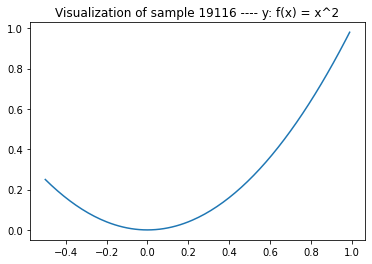

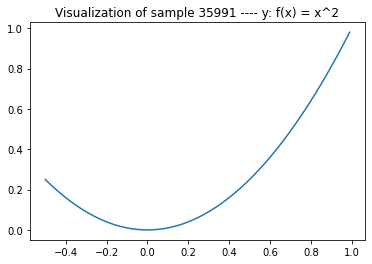

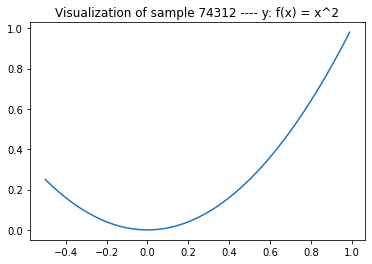

In [8]:
# Sample configuration
num_samples = 100000

# Intrasample configuration
interval_per_element = 0.01
total_num_elements = int(1 / interval_per_element)
starting_point = int(0 - 0.5*total_num_elements)

# Other configuration
num_samples_visualize = 3

# Containers for samples and subsamples
samples = []
xs = []
ys = []

# Generate samples
for j in range(0, num_samples):
  #if j % 100 == 0:
  #  print(j)
  # Generate wave
  for i in range(starting_point, total_num_elements):
    x_val = i * interval_per_element
    y_val = x_val * x_val
    xs.append(x_val)
    ys.append(y_val)
  # Append wave to samples
  samples.append((xs, ys))
  # Clear subsample containers for next sample
  xs = []
  ys = []

# Input shape
print(np.shape(np.array(samples[0][0])))
  
# Save data to file for re-use
np.save('./signal_waves_medium.npy', samples)

# Visualize a few random samples
for i in range(0, num_samples_visualize):
  random_index = np.random.randint(0, len(samples)-1)
  x_axis, y_axis = samples[random_index]
  plt.plot(x_axis, y_axis)
  plt.title(f'Visualization of sample {random_index} ---- y: f(x) = x^2')
  plt.show()

In [9]:
noise_factor = 0.05

In [10]:
data = np.load('./signal_waves_medium.npy')
x_val, y_val = data[:,0], data[:,1]

In [11]:
# Add noise to data
noisy_samples = []
for i in range(0, len(x_val)):
  #if i % 100 == 0:
  #  print(i)
  original = np.array(y_val[i])
  noise = np.random.normal(0, 1, original.shape)
  signal = original + noise_factor * noise
  noisy_samples.append([x_val[i], signal])

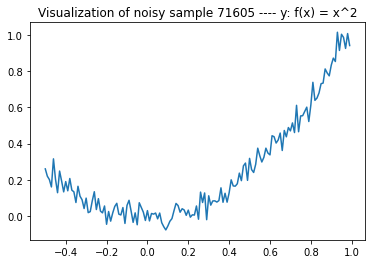

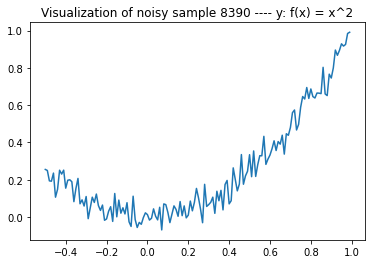

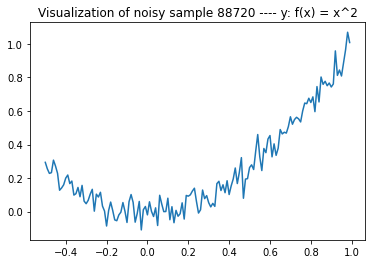

In [12]:
# Save data to file for re-use
np.save('./signal_waves_noisy_medium.npy', noisy_samples)

# Visualize a few random samples
for i in range(0, num_samples_visualize):
  random_index = np.random.randint(0, len(noisy_samples)-1)
  x_axis, y_axis = noisy_samples[random_index]
  plt.plot(x_axis, y_axis)
  plt.title(f'Visualization of noisy sample {random_index} ---- y: f(x) = x^2')
  plt.show()

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

In [15]:
# Model configuration
input_shape = (150, 1)
batch_size = 150
no_epochs = 10
train_test_split = 0.3
validation_split = 0.2

In [16]:
# Load data
data_noisy = np.load('./signal_waves_noisy_medium.npy')
x_val_noisy, y_val_noisy = data_noisy[:,0], data_noisy[:,1]
data_original = np.load('./signal_waves_medium.npy')
x_val_original, y_val_original = data_original[:,0], data_original[:,1]

In [17]:
# Reshape data
y_val_noisy_r = []
y_val_original_r = []

for i in range(0, len(y_val_noisy)):
  noisy_sample = y_val_noisy[i]
  original_sample = y_val_original[i]
  noisy_sample = (noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample))
  original_sample = (original_sample - np.min(original_sample)) / (np.max(original_sample) - np.min(original_sample))
  y_val_noisy_r.append(noisy_sample)
  y_val_original_r.append(original_sample)
  
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_original_r    = np.array(y_val_original_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
original_input      = y_val_original_r.reshape((y_val_original_r.shape[0], y_val_original_r.shape[1], 1))

In [18]:
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
original_input, original_input_test = original_input[:percentage_training], original_input[percentage_training:]

In [20]:
# Create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Conv1D(1, kernel_size=3, activation='sigmoid', padding='same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 148, 128)          512       
                                                                 
 conv1d_4 (Conv1D)           (None, 146, 32)           12320     
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 148, 32)          3104      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 150, 128)         12416     
 ranspose)                                                       
                                                                 
 conv1d_5 (Conv1D)           (None, 150, 1)            385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-trai

In [21]:
# Compile and fit data
model.compile(optimizer='adam', loss='mse')
model.fit(noisy_input, original_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Epoch 1/10
374/374 [==============================] - 16s 14ms/step - loss: 0.0075 - val_loss: 6.3174e-04
Epoch 2/10
374/374 [==============================] - 3s 8ms/step - loss: 6.4839e-04 - val_loss: 6.5561e-04
Epoch 3/10
374/374 [==============================] - 3s 8ms/step - loss: 6.2071e-04 - val_loss: 5.7425e-04
Epoch 4/10
374/374 [==============================] - 3s 8ms/step - loss: 6.0426e-04 - val_loss: 5.7221e-04
Epoch 5/10
374/374 [==============================] - 3s 9ms/step - loss: 6.0088e-04 - val_loss: 5.6615e-04
Epoch 6/10
374/374 [==============================] - 3s 8ms/step - loss: 5.9427e-04 - val_loss: 5.8155e-04
Epoch 7/10
374/374 [==============================] - 3s 8ms/step - loss: 5.9422e-04 - val_loss: 5.6261e-04
Epoch 8/10
374/374 [==============================] - 3s 9ms/step - loss: 5.8154e-04 - val_loss: 5.8346e-04
Epoch 9/10
374/374 [==============================] - 3s 8ms/step - loss: 5.8159e-04 - val_loss: 5.5521e-04
Epoch 10/10
374/374 [=========

In [22]:
# Generate reconstructions
num_reconstructions = 4
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

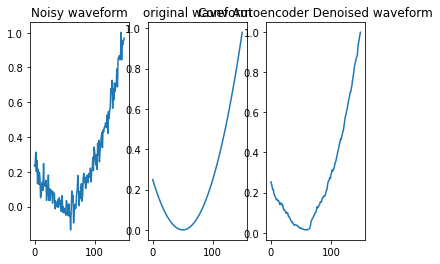

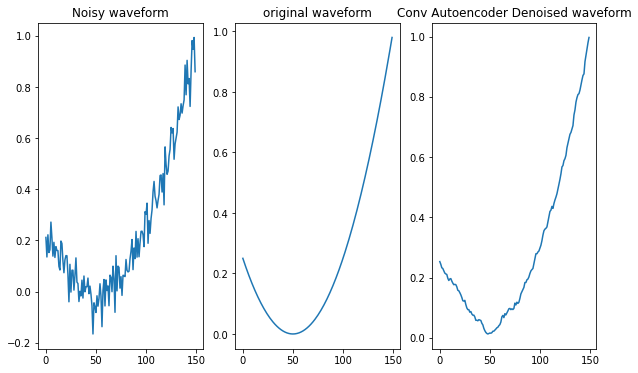

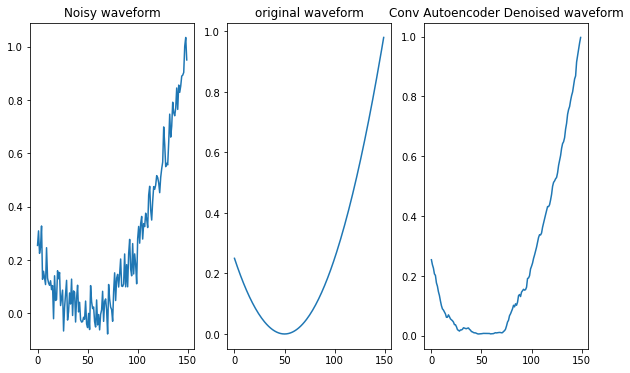

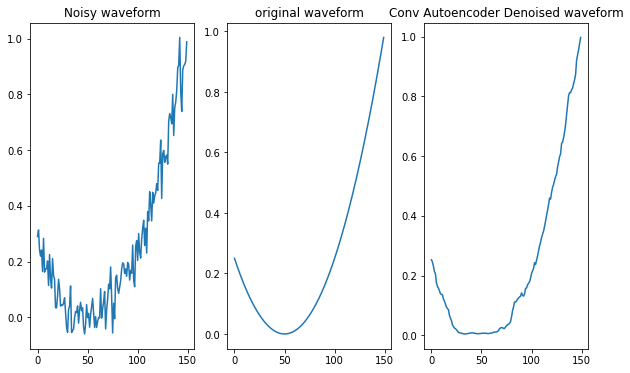

In [23]:
# Plot reconstructions
for i in np.arange(0, num_reconstructions):
  # Prediction index
  prediction_index = i + percentage_training
  # Get the sample and the reconstruction
  noisy = y_val_noisy[prediction_index]
  original = y_val_original[prediction_index]
  reconstruction = np.array(reconstructions[i])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  # Plot sample and reconstruciton
  axes[0].plot(noisy)
  axes[0].set_title('Noisy waveform')
  axes[1].plot(original)
  axes[1].set_title('original waveform')
  axes[2].plot(reconstruction)
  axes[2].set_title('Conv Autoencoder Denoised waveform')
  plt.rcParams["figure.figsize"] = (10,6)
  plt.show()